In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import AdamW

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Узнаем, что за карта
print(torch.cuda.get_device_name(0))

Tesla T4


In [8]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [9]:
df = pd.read_csv('/content/gdrive/My Drive/colab_data/leroymerlin/leroy.csv')
# Размер нашей выборки
df.shape

(358865, 7)

In [10]:
df.sample(5)

,category_1,category_2,category_3,name,madein,art,price
310711,Декор,Оформление интерьера,Римские шторы,"Штора римская «Лея», 100х160 см, цвет кремовый",Китай,81954963,1 032
44733,Электротовары,Удлинители и тройники,Реле и контроллеры,GSM модуль Котёл ОК,Китай,82163304,3 898
155604,Водоснабжение,Инструменты и аксессуары для труб,Фитинги для канализации,Хомут Политэк Ø 110 мм полипропилен,Китай,11012664,33
146662,Водоснабжение,Тепловые пушки и нагреватели,Трубы для внутренней канализации,Труба канализационная Ø 32 мм L 0.5м полипропилен,Китай,13567532,37
81961,Инструменты,Штукатурно-отделочные инструменты,Ручные измерительные инструменты,"Угольник комбинированный Kapro 352, 300 мм",Китай,82315922,1 964


In [11]:
df.category_1.unique()

array(['Стройматериалы', 'Столярные изделия', 'Окна и двери',
       'Электротовары', 'Инструменты', 'Напольные покрытия', 'Плитка',
       'Сантехника', 'Водоснабжение', 'Сад', 'Скобяные изделия', 'Краски',
       'Декор', 'Освещение', 'Хранение', 'Кухни'], dtype=object)

In [12]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится
# после обучения для большей наглядности, чтобы видеть, к какой категории товар
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [13]:
category_index

{'Стройматериалы': 0,
 'Столярные изделия': 1,
 'Окна и двери': 2,
 'Электротовары': 3,
 'Инструменты': 4,
 'Напольные покрытия': 5,
 'Плитка': 6,
 'Сантехника': 7,
 'Водоснабжение': 8,
 'Сад': 9,
 'Скобяные изделия': 10,
 'Краски': 11,
 'Декор': 12,
 'Освещение': 13,
 'Хранение': 14,
 'Кухни': 15}

In [14]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [15]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

('Штукатурка цементная Боларс Унипласт для блоков, кирпича и бетона 20 кг', 0)

In [16]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [17]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [18]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [19]:
len(train_sentences), len(test_sentences)

(357070, 1795)

In [23]:
!pip install sacremoses
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'DeepPavlov/rubert-base-cased', trust_repo=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 12.0 MB/s eta 0:00:00


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
# Токенизируем нашу обучающую выборку
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [25]:
# Посмотрим, что получилось
# Сомволы номеров отмечают то, что данный токен - продолжение слова
print(tokenized_texts[42])

['[CLS]', 'Нак', '##лей', '##ка', '«', 'Хорош', '##ее', 'утро', 'наступает', 'в', 'обед', '»', 'Дек', '##оре', '##т', '##то', '[SEP]']


In [26]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([1.44230e+04, 7.27330e+04, 1.48977e+05, 7.81750e+04, 3.59380e+04,
        4.80400e+03, 1.82600e+03, 1.82000e+02, 0.00000e+00, 1.20000e+01]),
 array([ 4. ,  8.5, 13. , 17.5, 22. , 26.5, 31. , 35.5, 40. , 44.5, 49. ]),
 <BarContainer object of 10 artists>)

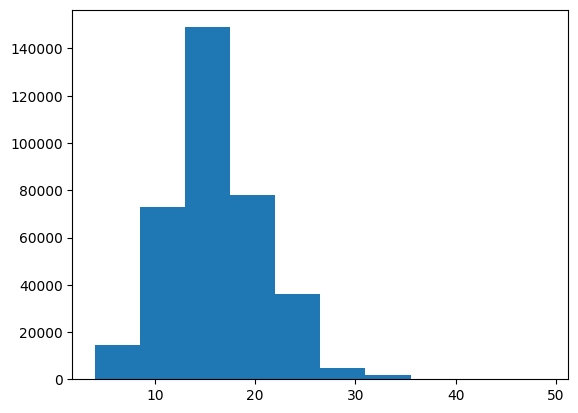

In [27]:

# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [28]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)


In [29]:
# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]

array([  101, 20481,  8903,  1714,   304, 27069,  2280, 34446, 38677,
         845, 37906,   326, 21870,  6869,   868,  1671,   102,     0,
           0,     0,     0,     0,     0,     0])

In [30]:
# Создадим маску внимания для каждого сэмпла нашей обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [31]:
print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [32]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [33]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category,
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)


In [34]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [35]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [37]:
from torch.utils.data.sampler import SequentialSampler
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)


In [38]:
config = AutoConfig.from_pretrained('DeepPavlov/rubert-base-cased',
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [39]:
# Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [41]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [42]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [43]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())

    # Обратный прогон
    loss[0].backward()

    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

********************
Лосс на обучении: 0.24843819095459754
CPU times: user 15min 21s, sys: 7min 27s, total: 22min 49s
Wall time: 23min 1s


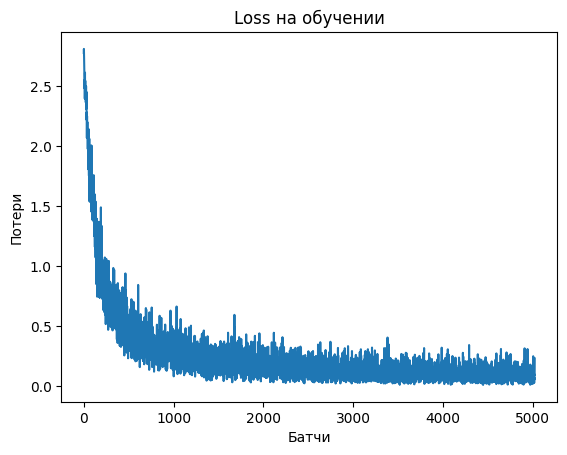

In [44]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [45]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch



    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


In [46]:
print(classification_report(valid_labels, valid_preds, target_names=category_index_reverce.values()))

                    precision    recall  f1-score   support

    Стройматериалы       0.98      0.96      0.97      1917
 Столярные изделия       1.00      0.98      0.99       494
      Окна и двери       1.00      0.86      0.92        83
     Электротовары       0.96      0.97      0.97      2706
       Инструменты       0.94      0.98      0.96      3326
Напольные покрытия       0.94      0.91      0.92       191
            Плитка       0.92      0.86      0.89       295
        Сантехника       0.98      0.97      0.98      3553
     Водоснабжение       0.98      0.99      0.99      3233
               Сад       0.98      0.98      0.98      8331
  Скобяные изделия       0.98      0.97      0.97      2619
            Краски       0.98      0.94      0.96      1644
             Декор       0.92      0.94      0.93      4272
         Освещение       0.92      0.82      0.87      1084
          Хранение       0.90      0.92      0.91       837
             Кухни       0.93      0.99

In [47]:
model.save_pretrained('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/')
tokenizer.save_pretrained('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/')

('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/tokenizer_config.json',
 '/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/special_tokens_map.json',
 '/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/vocab.txt',
 '/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/added_tokens.json',
 '/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2/tokenizer.json')

In [49]:
# config
config = AutoConfig.from_pretrained('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('/content/gdrive/My Drive/colab_data/leroymerlin/model/BERT_model2', config=config)


In [50]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [51]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Наименование товара: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()


Наименование товара: Направляющая для шкафа купе нижняя MC-L90-H 1800 мм нагрузка до 45 кг алюминий
Предсказанная категория: Скобяные изделия
Истинная категория: Скобяные изделия

Наименование товара: Цепь пильная Калибр 57 звеньев, шаг 3/8 дюйма, паз 1.3 мм
Предсказанная категория: Сад
Истинная категория: Сад

Наименование товара: Комплект натяжного потолка «Своими руками» №13 белый матовый 3,2х5 м
Предсказанная категория: Декор
Истинная категория: Декор

Наименование товара: Миксер KITFORT КТ-1367, 1200 Вт
Предсказанная категория: Кухни
Истинная категория: Кухни

Наименование товара: Клей монтажный прозрачный Момент МВп-70 суперсильный 280 г
Предсказанная категория: Декор
Истинная категория: Декор

Наименование товара: Система Кристалл ЭКО-Н Аквафор для жёсткой воды, 3 ступени
Предсказанная категория: Водоснабжение
Истинная категория: Водоснабжение

Наименование товара: Душевая кабина Macao Tetto высокий поддон 90х90 см
Предсказанная категория: Сантехника
Истинная категория: Сантехни

In [56]:
    sku_title = 'диск пильный по дереву'
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')

Предсказанная категория: Инструменты
